**Прогнозирование заказов такси**

Имеются данные о заказах такси в аэропортах. Для планирования количества водителей необходимо спрогнозировать количество заказов такси на следующий час. Для решения данной задачи построим модель, предсказывающую необходимые данные. Качество модели проверим метрикой RMSE. Значение метрики должно быть менее 48. План выполнения работы:

1. Подготовка данных. Проверим на наличие ошибок, дубликатов.    
2. Анализ данных. Проанализируем предоставленные данные.    
3. Обучение модели.     
4. Тестирование выбранной модели. Проверка качества работы метрикой RMSE. 

**1  Подготовка**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from lightgbm import LGBMRegressor

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
display(data.head())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
print(data.info)

<bound method DataFrame.info of                      num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32
...                         ...
2018-08-31 23:10:00          32
2018-08-31 23:20:00          24
2018-08-31 23:30:00          27
2018-08-31 23:40:00          39
2018-08-31 23:50:00          53

[26496 rows x 1 columns]>


In [4]:
print(data.shape)

(26496, 1)


In [5]:
data = data.resample('1H').sum()

In [6]:
data.isna().sum()

num_orders    0
dtype: int64

In [7]:
display(data.head())
print(data.shape)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


(4416, 1)


**2  Анализ**

Рассмотрим данные на графике.

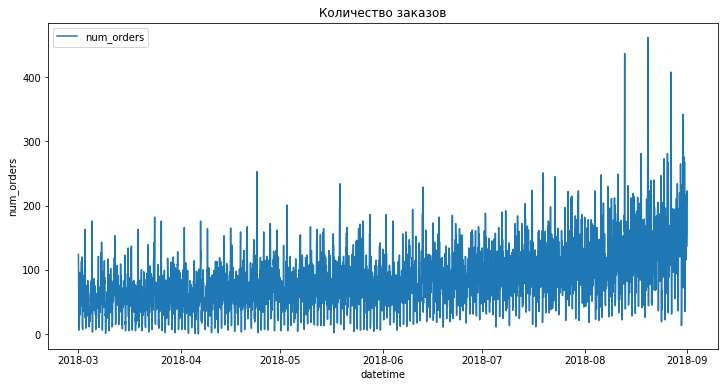

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(data)
plt.xlabel('datetime')
plt.ylabel('num_orders')
plt.title('Количество заказов')
plt.legend(['num_orders'])
plt.show()

Количество заказов от марта к сентябрю значительно возросло. В августе отмечается несколько часов очень сильной загруженности заказами. Для более детального рассмотрения выделим тренд и сезонность в предоставленных данных.

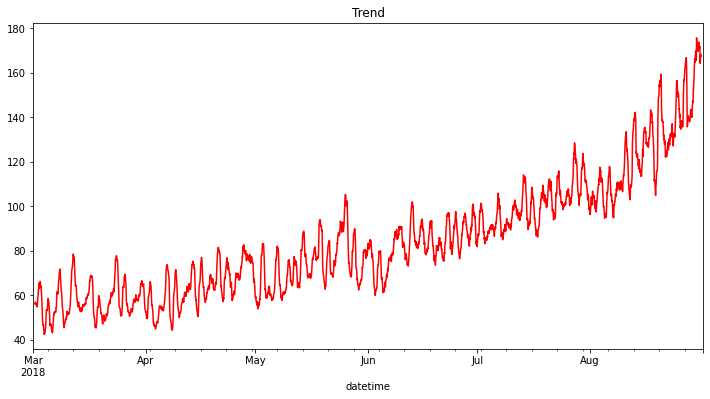

In [10]:
decomposed = seasonal_decompose(data)
plt.figure(figsize=(12, 6))
decomposed.trend.plot(ax=plt.gca(), color='red')
plt.title('Trend');

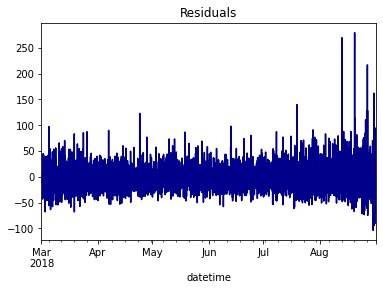

In [11]:
decomposed.resid.plot(ax=plt.gca(), color = 'darkblue')
plt.title('Residuals');

На графиках видно, что сезонности в данных нет, тренд на увеличение количества заказов в августе.

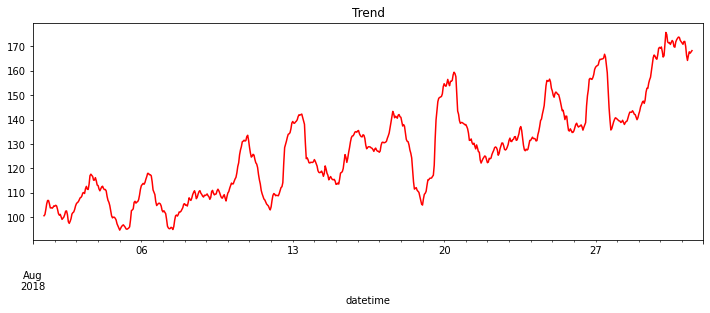

In [12]:
decomposed_month = seasonal_decompose(data['2018-08-01':'2018-08-31'])
plt.figure(figsize=(12, 4))
decomposed_month.trend.plot(ax=plt.gca(), color='red')
plt.title('Trend');

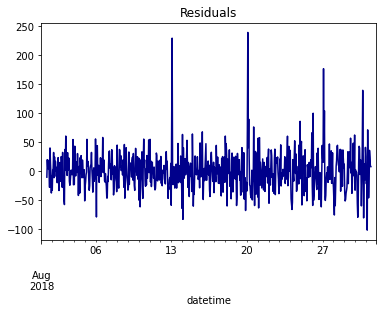

In [13]:
decomposed_month.resid.plot(ax=plt.gca(), color = 'darkblue')
plt.title('Residuals');

Уменьшение диапазона данных для более детального рассмотрения на графике подтверждает предыдущие выводы.

Сдвинем наши временные ряды вперед на 1 день, т.е. на 24 часа. Добавляем лаг 24 для создания дополнительных данных для более качественного прогнозирования будущей модели. И добавим скользящее среднее, которое сглаживает значения временного ряда. Для него возьмем параметр также равный одному дню - 24 часа.

In [14]:
def make_features(data, max_lag, rolling_mean_size):
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data
make_features(data, 24, 24)

,num_orders,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,164.875000
2018-08-31 20:00:00,154,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,167.541667
2018-08-31 21:00:00,159,154.0,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,168.041667


In [15]:
print(data.shape)

(4416, 26)


<Figure size 1440x720 with 0 Axes>

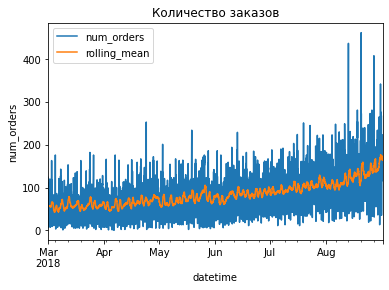

In [16]:
plt.figure(figsize=(20, 10))
data.plot(y=["num_orders", "rolling_mean"])
plt.xlabel('datetime')
plt.ylabel('num_orders')
plt.title('Количество заказов')
plt.legend(['num_orders', 'rolling_mean'])
plt.show();

**3  Обучение**

Разделим имеющиеся данные на выборки - обучающую, валидационную и тестовую. Размер тестовой выборки - 10% от общего количества данных.

In [17]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()
display(train.head())
display(test.head())
print(train.shape)
print(test.shape)

,num_orders,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,66.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,56.833333
2018-03-02 01:00:00,120,90.0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,55.416667
2018-03-02 02:00:00,75,120.0,90.0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,56.875000
2018-03-02 03:00:00,64,75.0,120.0,90.0,58.0,113.0,66.0,61.0,45.0,73.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,57.041667
2018-03-02 04:00:00,20,64.0,75.0,120.0,90.0,58.0,113.0,66.0,61.0,45.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,56.958333


,num_orders,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-13 14:00:00,102,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,...,118.0,135.0,98.0,82.0,78.0,115.0,153.0,149.0,104.0,138.541667
2018-08-13 15:00:00,175,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,...,185.0,118.0,135.0,98.0,82.0,78.0,115.0,153.0,149.0,138.458333
2018-08-13 16:00:00,144,175.0,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,...,160.0,185.0,118.0,135.0,98.0,82.0,78.0,115.0,153.0,139.541667
2018-08-13 17:00:00,152,144.0,175.0,102.0,119.0,92.0,144.0,156.0,137.0,91.0,...,273.0,160.0,185.0,118.0,135.0,98.0,82.0,78.0,115.0,139.166667
2018-08-13 18:00:00,104,152.0,144.0,175.0,102.0,119.0,92.0,144.0,156.0,137.0,...,437.0,273.0,160.0,185.0,118.0,135.0,98.0,82.0,78.0,140.708333


(3950, 26)
(442, 26)


In [18]:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

Для расчета качества метрики создадим функцию расчета RMSE.

In [19]:
def rmse(target, predictions):
    rmse = mean_squared_error(target, predictions)**0.5
    return rmse

In [20]:
rmse_score = make_scorer(rmse, greater_is_better = False)

Обучим различные модели

In [21]:
model = LinearRegression()
model.fit(features_train, target_train)
predictions = model.predict(features_train)
print("RMSE обучающей выборки:", rmse(target_train, predictions))

RMSE обучающей выборки: 25.960732583766678


In [22]:
model_2 = DecisionTreeRegressor(random_state=12345)
parameter = {'max_depth': range(2, 20, 2)}
tscv = TimeSeriesSplit(n_splits=6)
search_2 = GridSearchCV(estimator = model_2, cv=tscv, param_grid=parameter, scoring=rmse_score)
search_2.fit(features_train, target_train);

In [23]:
predictions_2 = search_2.predict(features_train)
print(search_2.best_params_)
print("RMSE обучающей выборки:", search_2.best_score_)

{'max_depth': 4}
RMSE обучающей выборки: -30.021598589899707


In [24]:
model_3 = LGBMRegressor(random_state=12345)
parameter = {'n_estimators': [40, 80, 10], 
             'max_depth': range(1, 10, 2)
             }
tscv = TimeSeriesSplit(n_splits=4)
search_3 = GridSearchCV(estimator = model_3, cv=tscv, param_grid=parameter, scoring=rmse_score)
search_3.fit(features_train, target_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
             estimator=LGBMRegressor(random_state=12345),
             param_grid={'max_depth': range(1, 10, 2),
                         'n_estimators': [40, 80, 10]},
             scoring=make_scorer(rmse, greater_is_better=False))

In [25]:
predictions_3 = search_3.predict(features_train)
print(search_3.best_params_)
print("RMSE обучающей выборки:", search_3.best_score_)

{'max_depth': 5, 'n_estimators': 80}
RMSE обучающей выборки: -26.52755683127402


При общем достаточно одинаковом уровне качества работы моделей, модель LinearRegressor выдала наилучший результат. К тому же данная модель рассчитывает прогнозы значительно быстрее остальных, требует меньше ресурсов. Рекомендуем её к использованию.

**4  Тестирование**

Проверим выбранную модель на тестовой выборке.

In [26]:
model_test = LinearRegression()
model_test.fit(features_train, target_train)
predictions_test = model.predict(features_test)
print("RMSE тестовой выборки:", rmse(target_test, predictions_test))

RMSE тестовой выборки: 45.02063796761042


Сравним предсказания модели с целевым значением.

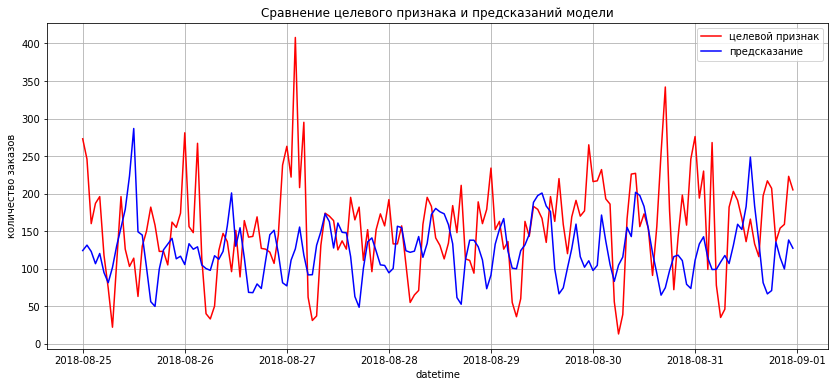

In [27]:
plt.figure(figsize = (14,6))
plt.plot(target_test['2018-08-25':'2018-08-31'].index, target_test['2018-08-25':'2018-08-31'], color='red')
plt.plot(target_test['2018-08-25':'2018-08-31'].index, predictions_test[:-274], color='blue')
plt.xlabel('datetime')
plt.ylabel('количество заказов')
plt.legend(['целевой признак', 'предсказание'])
plt.grid()
plt.title("Сравнение целевого признака и предсказаний модели");

Согласно требованиям, величина RMSE не должна превышать 48. Наша модель добилась требуемого результата, качество её работы удовлетворительно для заказчика. Рекомендуем применять именно данную модель.

**Заключение**

Были предоставлены данные о заказах такси в аэропортах за период март - август 2018. Для корректного планирования количества водителей необходим прогноз количества вызовов такси на следующий час. Необходимо найти удобную модель для получения необходимого прогноза, причем качество предсказанных данных должно быть проверено метрикой RMSE и не превышать 48.

1. Подготовка данных.

Рассмотрели предоставленные данные. Было учтено 26496 показаний о вызовах такси за период 01.03.2018 по 31.08.2018. Т.к. поставлена задача прогнозирования обращений в такси за час, поменяли интервал предоставленных данных - проверили ресемплирование, заданный интервал - 1 час. Данные проверили на наличие дубликатов и пропусков. Таких значений не обнаружено.

2. Анализ данных.

Данные достаточно удобно рассмотреть на графике. Имеется ряд выбросов значений, особенно в августе 2018 года. Также обнаруживается общее возрастание количества заказов. Для прогнозирования данных создали признаки - отстающие значения, добавили скользящее среднее для более наглядного общего тренда в изменении значений.

3. Обучение модели.

Для обучения моделей разделили общую выборку данных на обучающую, валидационную и тестовую. Удалили строки со значениями Nan. Для расчета качества модели создали функцию RMSE. Взяли для обучения 4 модели: LinearRegressor, DecisionTreeRegressor, RandomForestRefressor, LGBMRegressor. Для более полного тестирования оптимальные параметры подбирали через GridSearch. Полученнные результаты показывают примерно одинаковое качество работы всех моделей, поэтому к использованию рекомендуется модель LinearRegressor, как занимающая наименьшее количество ресурсов для расчета, выдающая результат максимально быстро.

4. Тестирование выбранной модели.

Проверка качества работы модели LinearRegressor метрикой RMSE выдала результат 46, что соответствует требованиям, предъявляемым к работе модели. Модель LinearRegressor рекомендуется для решения поставленной задачи прогнозирования.